# Visualização do funcionamento do algoritmo do Kapetanovic

Esse jupyter tem como objetivo verificar o funcionamento do esquema de detecção de contaminação piloto 1B do artigo do Kapetanovic. O esquema é baseado na razão dos dois maiores autovalores da matriz R. Vamos ver como essa razão é alterada em função do número de usuários conectados na rede, qtd de antenas, SNR, e qtd de símbolos na sequência piloto.

### Importações

O arquivo "comm" possui as funções necessárias para simular a modulação QPSK, adicionar ruído branco na transmissão, e, por último, uma função que constroi a matriz R e retorna a razão de seus dois maiores autovalores.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import sys
from IPython.display import display, clear_output

sys.path.append("../Python/")
import comm

In [2]:
#DEFININDO ALGUNS PARÂMETROS DO GRÁFICO
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {
    'figure.figsize': [21, 3],
    'figure.titlesize': 12, 
    'axes.labelsize': 8,
    'axes.titlesize': 10, 
    'font.size': 8,
    'legend.fontsize': 8, 
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
    'axes.axisbelow': True
}
plt.rcParams.update(params)

### Definição de Funções

In [3]:
def simularPropagacaoSinal(qtdSimbolosPiloto, bitsPorSimbolo, qtdAntenas, qtdUsuarios, potenciaEspiao, snr, qtdEspioes=1):
    
    # SIMULANDO OS CANAIS DO USUARIO E DO ESPIAO
    Haut = np.sqrt(0.5)*(np.random.normal(0, 1, size=(qtdAntenas, qtdUsuarios)) + 1j*np.random.normal(0, 1, size=(qtdAntenas, qtdUsuarios)))
    g    = np.sqrt(0.5)*(np.random.normal(0, 1, size=(qtdAntenas, qtdEspioes)) + 1j*np.random.normal(0, 1, (qtdAntenas, qtdEspioes)))

    # SEQUENCIA PILOTO ALEATORIA + MODULACAO PARA TODOS OS USUARIOS:
    bitStream = np.random.choice([0, 1], qtdSimbolosPiloto*bitsPorSimbolo*qtdUsuarios)
    symb      = comm.qpskmodulator(bitStream) # QPSK Modulator
    xp        = symb.reshape(qtdUsuarios, qtdSimbolosPiloto)

    # ESPIAO ENTRANDO NA JOGADA (SE A POTENCIA DELE FOR 0 ELE NAO ENTRA NA JOGADA):
    xpe  = np.sqrt(potenciaEspiao)*xp[0, :] # xpe vai ser a sequencia piloto do primeiro usuario multiplicada pela raiz da potencia do espiao
    xptx = np.concatenate((xp, [xpe])) # xptx sera a matriz xp com uma linha a mais: xpe
    H    = np.concatenate((Haut, g), axis=1) # H vai ser Haut com uma COLUNA a mais, que vai ser g

    # TRANSMISSAO PELO CANAL
    Y = np.dot(H, xptx) # fading
    Y = comm.awgn(Y, SNR=snr) # ruido branco
    
    return Y

In [4]:
def printar(qtdUsuariosAtual, qtdAntenasAtual, rangePotenciaEspiao, rangeQtdSimbolos, limiteEixoY=None):
    
    fig, axs  = plt.subplots(1, len(rangePotenciaEspiao))
    eixoAtual = 0

    for potenciaEspiaoAtual in rangePotenciaEspiao:
        axs[eixoAtual].set_title("Potência Espião: "+str(potenciaEspiaoAtual))

        for qtdSimbolosAtual in rangeQtdSimbolos:        
            eixoSNRs          = []
            mediaParaCadaSNR  = []
            desvioParaCadaSNR = []  

            for chaveAtual in dictGlobal:
                if dictGlobal[chaveAtual]["qtdAntenas"] == qtdAntenasAtual and dictGlobal[chaveAtual]["qtdUsuarios"] == qtdUsuariosAtual and dictGlobal[chaveAtual]["potenciaEspiao"] == potenciaEspiaoAtual and dictGlobal[chaveAtual]["qtdSimbolos"] == qtdSimbolosAtual:
                    eixoSNRs.append(dictGlobal[chaveAtual]["snr"])
                    mediaParaCadaSNR.append(dictGlobal[chaveAtual]["mediaRazoes"])
                    desvioParaCadaSNR.append(dictGlobal[chaveAtual]["desvioRazoes"])

            axs[eixoAtual].errorbar(eixoSNRs, mediaParaCadaSNR, yerr=desvioParaCadaSNR, fmt="--", label=str(qtdSimbolosAtual)+" símbolos")

        axs[eixoAtual].legend()
        axs[eixoAtual].set_xlabel("SNR")
        axs[eixoAtual].set_ylabel("Razão dos Autovalores")
        axs[eixoAtual].grid(alpha=0.5)
        if limiteEixoY != None: 
            axs[eixoAtual].set_ylim(0, limiteEixoY)    
        eixoAtual += 1

    fig.suptitle(str(qtdUsuariosAtual) + " Usuário(s) - " + str(qtdAntenasAtual) + " Antenas\n\n", y=1.1)
    fig.show()

### Parâmetros Fixos

In [5]:
qtdEspioes        = 1
qtdBitsPorSimbolo = 2
repetibilidade    = 10
potenciaUsuario   = 1

### Parâmetros Variáveis

In [6]:
rangeQtdUsuarios    = np.arange(1, 3)
rangeQtdAntenas     = np.array([64, 128, 256])
rangePotenciaEspiao = np.arange(0.0, 2.1, 0.5)
rangeQtdSimbolos    = np.arange(15, 101, 15)
rangeSNRs           = np.arange(-10, 21, 5)

### Rodando a Simulação

In [7]:
dictGlobal        = {} # dicionario que vai guardar os resultados de cada iteracao
iteracaoAtual     = 1 # para contar as iteracoes e printar um percentual de progresso
qtdPossibilidades = len(rangeQtdUsuarios) * len(rangeQtdAntenas) * len(rangePotenciaEspiao) * len(rangeQtdSimbolos) * len(rangeSNRs) * repetibilidade

for qtdUsuariosAtual in rangeQtdUsuarios: # Tirar este cara
    for qtdAntenasAtual in rangeQtdAntenas:
        for potenciaEspiaoAtual in rangePotenciaEspiao:
            for qtdSimbolosAtual in rangeQtdSimbolos:
                for snrAtual in rangeSNRs:
                    # VARIAR THRESHOLD
                    
                    # ESTABELECIDO UM CENARIO, VAMOS PARTIR PRA REPETIBILIDADE
                    arrayRazoesCenarioAtual = []
                    for repetibilidadeAtual in range(repetibilidade):

                        # PROPAGACAO DO SINAL
                        Y = simularPropagacaoSinal(qtdSimbolosAtual, qtdBitsPorSimbolo, qtdAntenasAtual, qtdUsuariosAtual, potenciaEspiaoAtual, snrAtual, qtdEspioes)

                        # CALCULANDO A RAZAO DOS AUTOVALORES
                        arrayRazoesCenarioAtual.append(comm.razaoMatrizR(Y, qtdSimbolosAtual, M=qtdAntenasAtual, SNR=snrAtual))
                        
                        # CALCULANDO A PROBABILIDADE DE DETCçÃO
                        
                        
                        # CALCULAR FALSO POSITIVO
                        
                        
                        # PRINT
                        clear_output(wait=True)
                        display("Progresso: " + str(100*(iteracaoAtual/qtdPossibilidades))[:7] + "%")
                        iteracaoAtual += 1
                        
                    # ARMAZENANDO O RESULTADO DO CENARIO ATUAL
                    dictGlobal[int(iteracaoAtual/repetibilidade)] = {
                        "qtdUsuarios":    qtdUsuariosAtual, 
                        "qtdAntenas":     qtdAntenasAtual, 
                        "potenciaEspiao": potenciaEspiaoAtual, 
                        "qtdSimbolos":    qtdSimbolosAtual, 
                        "snr":            snrAtual, 
                        "mediaRazoes":    np.mean(arrayRazoesCenarioAtual), 
                        "desvioRazoes":   np.std(arrayRazoesCenarioAtual) 
                    }

'Progresso: 100.0%'

## Visualizando

### 1 usuário conectado

c:\users\pedro ivo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


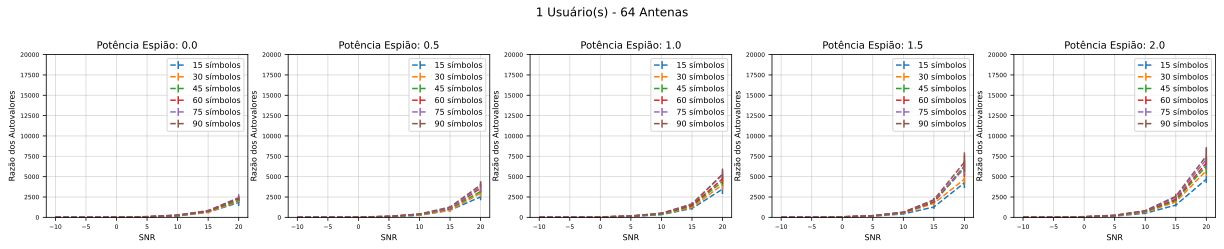

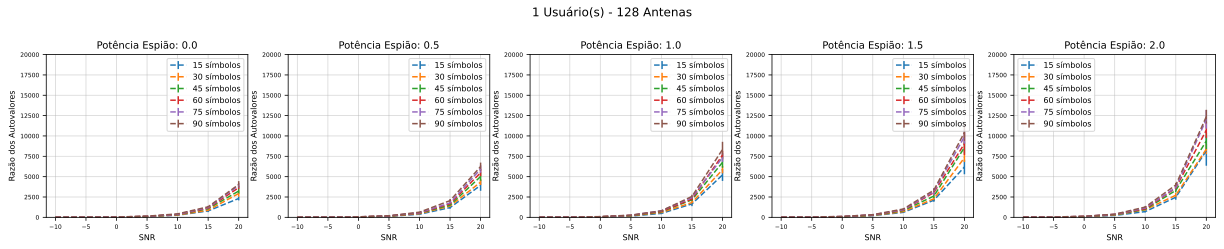

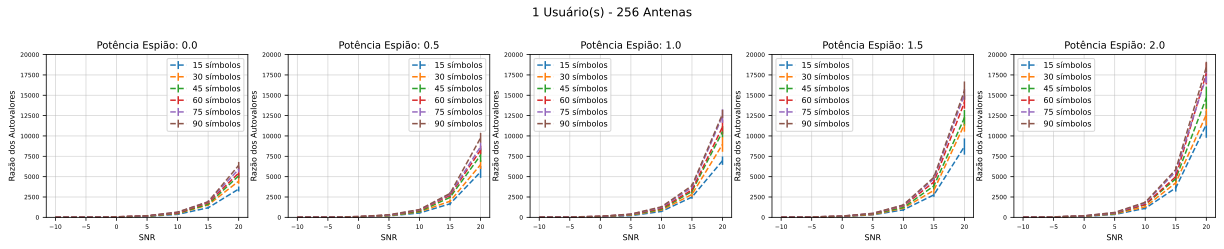

In [8]:
for qtdAntenasAtual in rangeQtdAntenas:
    printar(rangeQtdUsuarios[0], qtdAntenasAtual, rangePotenciaEspiao, rangeQtdSimbolos, limiteEixoY=20000)

### SNR fixa, plota Probabilidade de detecção versus threshold

### Threshold fixo, Probabilidade versus SNR